In [1]:
"""
- BUILDS SEVERAL TRAJECTORIES BASED ON CAPTURED WAYPOINTS, SAVES THEM INTO A RADA FILE
- REPLAYS ALL THE TRAJECTORIES (WITH SHORT PAUSES TO REPOSITION THE CUBE), WHILE DENSELY RECORDING 
  JOINT ANGLES AND VIDEO FRAMES. RECORDS INTO 'RAD0.dat', 'RAD1.dat' FILES
      DICTIONARIES WITH KEYS ('joints', 'igm', 't')
- ALLOWS ONE TO SEE VIDEO AND JOINT ANGLES FROM RECORDED TRAJECTORIES
"""
print()

()


In [1]:
from __future__ import print_function
import sys, os
import time
import pickle
import rospy
import numpy as np
from scipy import signal
import scipy
from sensor_msgs.msg import Image
from cv_bridge import CvBridge, CvBridgeError
import cv2

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from termcolor import colored
from enum import Enum

# wrapper/helper functions
sys.path.insert(0, '/home/torobo/catkin_ws/src/torobo_robot/torobo_rnn/scripts')
sys.path.insert(0, '/home/torobo/catkin_ws/src/tutorial/PyTorch-YOLOv3')

from torobo_rnn_utils__upd3 import *
from torobo_driver import torobo_easy_command

from detect_upd import Recog, Recog2
from adjustExtForce_v3Controller import ExtForce

plt.switch_backend('nbAgg')

bridge = CvBridge()
torobo = ToroboOperator()
        
def echo(txt):
    sys.stdout.write('\r {}'.format(txt))
    sys.stdout.flush()
    
class NewRec(threading.Thread):

    """ RECORDS A DATASET FOR THE RNN """
    
    def __init__(self):
        threading.Thread.__init__(self)
        self.recording = False
        self.step = 0.1
        self.data = {}
    
    def run(self):
        if self.recording == True:
            self.recording = False
            print('Killing the previous recorder')
            time.sleep(1.5)
        self.recording = True
        self.record()
    
    def stop(self):
        self.recording = False
        time.sleep(1)
        print('Recording is {}'.format('ON' if self.is_alive() else 'OFF'))
        
        self.data['img'] = np.stack(self.data['img'])
        self.data['joints'] = np.stack(self.data['joints'])
        self.data['t'] = np.stack(self.data['t'])
        with open(self.fname, 'wb') as f:
            pickle.dump(self.data, f)
        print('Data saved')

        
    def record(self):
        global torobo, imagebuff
        print('Recording is {}'.format('ON' if self.is_alive() else 'OFF'))
        # overwrite
        if self.fname in os.listdir("."):
            open(self.fname, 'w').close()
        t = 0
        start_t = time.time()
        self.data['joints'] = []
        self.data['img'] = []
        self.data['t'] = []
        while self.recording:
            self.data['joints'].append(np.radians(get_cur_joints(torobo)[0]))
            self.data['img'].append(cv2.resize(imagebuff, (64,64), interpolation = cv2.INTER_AREA) )
            self.data['t'].append(time.time()-start_t)
            time.sleep(self.step)
            t += self.step

class Tracker(threading.Thread):
    """ - LOADS THE YOLO MODEL
        - FORWARD PASSES THE FRAME THROUGH THE MODEL
        - STORES BOUNDING BOX COORDINATES IN SELF.
    """
    
    def __init__(self):
        threading.Thread.__init__(self)
        
        checkpoint = 42
        self.recog = Recog2(checkpoint)
        self.box_cener = (0.0, 0.0)
        self.x1, self.y1, self.x2, self.y2 = 0.0, 0.0, 0.0, 0.0
        self.new_hor = 0
        self.new_ver = 0
        self.Norm = scipy.stats.norm(0, 20)
        self.scale = self.Norm.pdf(0)
        self.lasttime = 0.0
        
        self.keepgoing = False

    def stop(self):
        self.keepgoing = False
        print(colored('TRACKER STOPPED', 'white', 'on_red'))

    def get_gaze_offset(self, cx, cy):
        return 640/2 - cx, 480/2 - cy
    
    def get_gaze_grad(self, offset_x, offset_y):
        ex = 0.2 * np.tanh(0.025*(offset_x))/ (1+self.Norm.pdf(offset_x)/self.scale*4)
        ey = 0.2 * np.tanh(0.025*(offset_y))/ (1+self.Norm.pdf(offset_x)/self.scale*4)
        return ex, ey

    def get_box_center(self, x1, y1, box_w, box_h):
        self.box_cener = (x1 + box_w/2, y1 + box_h/2)
        return x1 + box_w/2, y1 + box_h/2

    def track_obj(self, x,y,w,h):
        global torobo
        cx, cy = self.get_box_center(x, y, w, h)
        gaze_offset = self.get_gaze_offset(cx,cy)
        ex, ey = self.get_gaze_grad(*gaze_offset)
        hor, ver = get_cur_joints(torobo)[0][14:16]
        self.new_hor, self.new_ver = np.radians(hor)+ex, np.radians(ver)-ey
        self.move()
        
    def move(self):
        global torobo
        if time.time() - self.lasttime > 0.2:
            self.lasttime = time.time()
            hor, ver = self.new_hor, self.new_ver
            torobo.move_joint_my (controller_id=ToroboOperator.TORSO_HEAD,
                                  joint_ids = [0, 1, 2, 3],
                                  positions=[0, np.radians(38.0), hor, ver],
                                  velocities=None,
                                  accelerations=None,
                                  duration=0.2)
        else:
            pass       

    def run(self):
        global imagebuff
        self.keepgoing = True
        while True and self.keepgoing:
            detections = self.recog.detect(imagebuff)
            if detections is not None:
                for det in detections:
                    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
                        if cls_pred == 0:
                            box_w = x2 - x1
                            box_h = y2 - y1
                            self.x1, self.y1, self.x2, self.y2 = x1, y1, x2, y2
                            x, y, w, h = x1, y1, box_w, box_h
                            self.track_obj(x, y, w, h)

     
        

class ExtForce(object):
    # SETS THE KINEMATIC MODEL PARAMETERS (BOTH IN HENDRY'S AND FACTORY FIRMWARE)

    class Mode(Enum):
        Teaching = 0
        Experiment = 1

    def runCommands(self, _commandList, _controller):
          for command in _commandList:
                torobo_easy_command.SendEasyCommandText(_controller, command)
                rospy.sleep(0.01)

    def registerParameters(self, tau_th, kp, sum_e_max, d, kr, theta_th):
            # left and right arm 
            for i in range(0,6):
                
                # constructing the commands for the left arm
                commandList = []				
                commandList.append("param " + str(i+1) + " fftauth " +       str(tau_th[i]))
                commandList.append("param " + str(i+1) + " ffkp " +          str(kp[i]))
                commandList.append("param " + str(i+1) + " ffsigmaemax " +   str(sum_e_max[i]))
                commandList.append("param " + str(i+1) + " ffdamping " +     str(d[i]))
                commandList.append("param " + str(i+1) + " ffkr " +          str(kr[i]))
                commandList.append("param " + str(i+1) + " softki " +        str(theta_th[i]))	


                # send to execution
                self.runCommands(commandList, "left_arm_controller")

            # right arm 
            for i in range(0,6):
                ii = i + 6 
                # constructing the commands for the right arm
                commandList = []
                commandList.append("param " + str(i+1) + " fftauth " +       str(tau_th[ii]))
                commandList.append("param " + str(i+1) + " ffkp " +          str(kp[ii]))
                commandList.append("param " + str(i+1) + " ffsigmaemax " +   str(sum_e_max[ii]))
                commandList.append("param " + str(i+1) + " ffdamping " +     str(d[ii]))
                commandList.append("param " + str(i+1) + " ffkr " +          str(kr[ii]))
                commandList.append("param " + str(i+1) + " softki " +        str(theta_th[ii]))	

                # send to execution
                self.runCommands(commandList, "right_arm_controller")
                            
            for i in range(0,4):
                ii = i + 12 
                # constructing the commands for the head-torso chain
                commandList = []				
                commandList.append("param " + str(i+1) + " fftauth " +       str(tau_th[ii]))
                commandList.append("param " + str(i+1) + " ffkp " +          str(kp[ii]))
                commandList.append("param " + str(i+1) + " ffsigmaemax " +   str(sum_e_max[ii]))
                commandList.append("param " + str(i+1) + " ffdamping " +     str(d[ii]))
                commandList.append("param " + str(i+1) + " ffkr " +          str(kr[ii]))
                commandList.append("param " + str(i+1) + " softki " +        str(theta_th[ii]))	

                # send to execution
                self.runCommands(commandList, "torso_head_controller")


    def __init__(self, _mode):	
        
        if _mode == ExtForce.Mode.Teaching:

            tau_th = [2.0, 2.0, 1.0, 1.0, 0.5, 0.5,            2.0, 2.0, 1.0, 1.0, 0.5, 0.5,      20.5, 20.5, 20.5, 20.5]
            kp = [0.1, 0.1, 0.05, 0.05, 0.1, 0.1,            0.1, 0.1, 0.05, 0.05, 0.1, 0.1,        0.0,0.0,0.0,0.0]
            sum_e_max = [200.0,200.0,100.0,100.0,50.0,50.0,  200.0,200.0,100.0,100.0,50.0,50.0,   200.0,200.0,50.0,50.0]
            d = [0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9]
            # kr = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
            kr = [0.1]*16
            kr[5] = 0.3
            kr[11] = 0.3
            theta_th = [1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57]
            theta_th = [i*1.63 for i in theta_th]

            self.registerParameters( tau_th, kp, sum_e_max, d, kr, theta_th)


        elif _mode == ExtForce.Mode.Experiment:

            tau_th = [12.0,12.0,5.0,5.0,1.5,1.5,12.0,12.0,5.0,5.0,1.5,1.5,200.0,200.0,200.0,200.0]
            kp = [0.025,0.025,0.05,0.05,0.1,0.1,0.025,0.025,0.05,0.05,0.1,0.1,0.025,0.025,0.05,0.05]
            sum_e_max = [200.0,200.0,100.0,100.0,50.0,50.0,200.0,200.0,100.0,100.0,50.0,50.0,200.0,200.0,50.0,50.0]
            d = [0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9]
            kr = [0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8]
            # kr = [0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9]
            theta_th = [1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57]
            theta_th = [i*1.63 for i in theta_th]

            self.registerParameters( tau_th, kp, sum_e_max, d, kr, theta_th)
            

    
    
def gostart(torobo):
    """ GO TO STARTING POSITION """
    idx = 4
    TIME = 5
    try:
        with HiddenPrints():
            servo_on(torobo)
            set_softness_override(torobo, 10.0)
            set_velocity_override(torobo, 10.0)
            with open('rad.pickle', 'rb') as f:
                RAD = pickle.load(f)

            left_arm_positions = RAD[idx][0:6]
            right_arm_positions = RAD[idx][6:12]
            torso_head_positions = RAD[idx][12:16]

            torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=TIME)
            torobo.move(ToroboOperator.RIGHT_ARM, positions=left_arm_positions, duration=TIME)
            torobo.move(ToroboOperator.TORSO_HEAD, positions=torso_head_positions, duration=TIME)
            rospy.sleep(TIME+0.1)
        print(colored('SUCCESS', 'white', 'on_green'))
    except:
        print('ERROR')
    

def setModeOverrides(torobo):
    """SET THE NEEDED KINEMATIC PARAMETERS AND MODES, OVERRIDES ON THE RIGHT JOINTS"""
    print('SETTING MODE: set_external_force_following_online_trajectory_control')
    with HiddenPrints():
        set_external_force_following_online_trajectory_control(torobo)
        torobo.set_control_mode(ToroboOperator.TORSO_HEAD, ['torso_head/joint_1',
                                                            'torso_head/joint_2'],
                                'position')
    print('SETTING DYNAMIC PARAMETERS')
    with HiddenPrints():
        time.sleep(1)
        ExtForce(ExtForce.Mode.Teaching)
        time.sleep(1)
    print('OVERRIDES SET')
    with HiddenPrints():
        set_softness_override(torobo, 10.0)
        set_velocity_override(torobo, 30.0)
        
def Monitor(tracker):
    cv2.namedWindow('I see')
    cv2.setWindowProperty("I see", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)

    while True:
        try:
            center_coordinates = tuple(np.round(tracker.box_cener).astype('int'))
            radius = 20
            color = (255, 0, 0) 
            thickness = 2
            image = cv2.cvtColor(imagebuff, cv2.COLOR_RGB2BGR)
            image = cv2.rectangle(image, (int(tracker.x1), int(tracker.y1)), (int(tracker.x2), int(tracker.y2)), color, thickness) 
            cv2.imshow('I see', image)
            k = cv2.waitKey(3) & 0XFF
            if k== 27 :
                cv2.destroyWindow('I see')
                break
        except:
            print('error')
            cv2.destroyWindow('I see')
            break

In [2]:
if not 'bridge' in locals():
    bridge = CvBridge()
if not 'torobo' in locals():
    torobo = ToroboOperator()
if not 'imagebuff' in locals():
    imagebuff = 0
    def image_callback(msg):
        global imagebuff
        imagebuff = bridge.imgmsg_to_cv2(msg, "rgb8") 
    rospy.Subscriber("/camera/color/image_raw", Image, image_callback)
    time.sleep(0.5)

with HiddenPrints():
    servo_on(torobo)
    
gostart(torobo)
setModeOverrides(torobo)

SUCCESS
SETTING MODE: set_external_force_following_online_trajectory_control
SETTING DYNAMIC PARAMETERS
OVERRIDES SET


In [3]:
""" TURN ON VIDEOSTREAMING FROM THE ROBOT'S CAMERA
    AND CHECK THE TRACKER IS WORKING (if you no window shows up, restart the kernel)
"""

SRATE = 10
""" REPLAY @ 5 HZ, RECORD AT 10 HZ """
INTERVAL = 0.2


tracker = Tracker()
tracker.start()
Monitor(tracker)
time.sleep(5)
tracker.stop()
print('RESTART THE KERNEL HERE')

TRACKER STOPPED
RESTART THE KERNEL HERE


In [3]:
"""
REPLAY ALL THE TRAJECTORIES (WITH SHORT PAUSES TO REPOSITION THE CUBE),
WHILE DENSELY RECORDING JOINT ANGLES AND VIDEO FRAMES
"""

TIME = 3

# start the tracker (moves the head independently)
tracker = Tracker()
tracker.start()

# start the monitor (let's you see how YOLO works online)
# monitor = threading.Thread(target=Monitor, args=[tracker])
# monitor.start()

# LOAD THE WAYPOINTS
with open('RADA.pickle', 'rb') as f:
    RADA = pickle.load(f)

# set position mode for the hands 
with HiddenPrints():
    torobo.set_control_mode(ToroboOperator.LEFT_ARM, 'all', 'position')
    torobo.set_control_mode(ToroboOperator.RIGHT_ARM, 'all', 'position')

for traj_name in RADA.keys():
    data_rec = NewRec()
    data_rec.fname = '{}_w_head_tracking.dat'.format(traj_name)
    data_rec.start()
    
    for a in [RADA[traj_name][1:], reversed(RADA[traj_name][:-1])]:

        for pos in a:
            left_arm_positions = pos[0:6]
            right_arm_positions = pos[6:12]
            
            # torso is controlled independetly by the tracker object in the background
            # torso_head_positions = pos[12:16]

            torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=TIME)
            torobo.move(ToroboOperator.RIGHT_ARM, positions=right_arm_positions, duration=TIME)
            # torso is controlled independetly by the tracker object in the background
            # torobo.move(ToroboOperator.TORSO_HEAD, positions=torso_head_positions, duration=TIME)
            rospy.sleep(TIME-0.4)
    data_rec.stop()
    time.sleep(4)      # sleep between trajectories (so you can shif the cube to a different location)

# monitor.join()
tracker.stop()
time.sleep(2)
print(tracker.is_alive())
# print(monitor.is_alive())

TRACKER STOPPED
False


# Don't run the following few lines unless you want to OVERWRITE the waypoints

In [ ]:
# BUILDS SEVERAL TRAJECTORIES BASED ON CAPTURED WAYPOINTS, SAVES THEM INTO A RADA FILE

In [6]:
# Create a dictionary to hold the future data
RADA = {}

In [7]:
# Go to the START position
idx = 4
TIME = 3
torobo.set_control_mode(ToroboOperator.LEFT_ARM, 'all', 'position')
torobo.set_control_mode(ToroboOperator.RIGHT_ARM, 'all', 'position')
with open('rad.pickle', 'rb') as f:
    RAD = pickle.load(f)
    
left_arm_positions = RAD[idx][0:6]
right_arm_positions = RAD[idx][6:12]
torso_head_positions = RAD[idx][12:16]

torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=TIME)
torobo.move(ToroboOperator.RIGHT_ARM, positions=left_arm_positions, duration=TIME)
torobo.move(ToroboOperator.TORSO_HEAD, positions=torso_head_positions, duration=TIME)
rospy.sleep(TIME+0.1)

[INFO] [1595741157.213540]: set_control_mode service client is called
[INFO] [1595741157.221349]: set_control_mode [['all']] is succeeded
[INFO] [1595741157.222658]: set_control_mode service client is called
[INFO] [1595741157.227448]: set_control_mode [['all']] is succeeded


In [70]:
# CREATE AN EMPTY NEW TRAJECTORY
traj_name = 'RAD2' # 'RAD0', 'RAD1', 'RAD2'
RADA[traj_name] = []
torobo.set_control_mode(ToroboOperator.LEFT_ARM, 'all', 'external_force_following')
torobo.set_control_mode(ToroboOperator.RIGHT_ARM, 'all', 'external_force_following')

[INFO] [1594602984.053188]: set_control_mode service client is called
[INFO] [1594602984.055639]: set_control_mode [['all']] is succeeded
[INFO] [1594602984.056050]: set_control_mode service client is called
[INFO] [1594602984.057633]: set_control_mode [['all']] is succeeded


In [78]:
# RECORD THE CURRENT WAYPOINT, AND APPEND IT TO THE CURRENT TRAJECTORY
cur_pos_deg, _ = get_cur_joints(torobo)
cur_pos_rad = np.radians(cur_pos_deg)
RADA[traj_name].append(cur_pos_rad)

In [79]:
# CHECK THE LENGHT OF THE CURRENT TRAJECTORY
len(RADA[traj_name])

5

In [82]:
# SAVE THE WAYPOINTS
with open('RADA.pickle', 'wb') as f:
    pickle.dump(RADA, f)

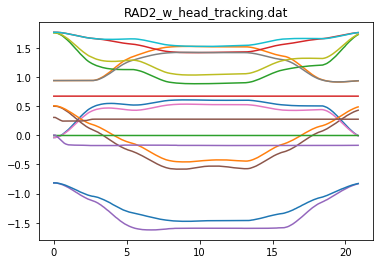

In [6]:
# SEE VIDEO FROM RECORDED TRAJECTORIES

traj_name = 'RAD2_w_head_tracking.dat'

%matplotlib inline
with open(traj_name, 'rb') as f:
    DAT = pickle.load(f)
    

cv2.namedWindow('I see')
cv2.setWindowProperty("I see", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)


i = 1

while True:
    try:
        time.sleep(0.1)
        img = DAT['img'][i,:,:,:].astype('uint8')
        img = np.copy(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        
        cv2.imshow('I see', img)
        k = cv2.waitKey(3) & 0XFF
        i += 1
        if k== 27 :
            cv2.destroyWindow('I see')
            break
    except:
        cv2.destroyWindow('I see')
        break

x = plt.plot(DAT['t'], DAT['joints'])
x = plt.title(traj_name)

In [3]:
# SEE THE VIDEO FEED

import cv2
import numpy as np
import time
import pickle


cv2.namedWindow('I see')
cv2.setWindowProperty("I see", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)


i = 1

while True:
    try:
        time.sleep(0.1)
        img = imagebuff.astype('uint8')
        img = np.copy(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        
        cv2.imshow('I see', img)
        k = cv2.waitKey(3) & 0XFF
        i += 1
        if k== 27 :
            cv2.destroyWindow('I see')
            break
    except:
        cv2.destroyWindow('I see')
        break